# Trevor Project Take Home Assignment (coding part)

### There are 4 parts to this assignment:
- Ingest provided data into the Google's BigQuery environment
- Extract that data from BigQuery into the coding environment of choice
- Transform the data to answer the following:
    - calculate the largest number of users that have been logged on at the same
time as each user
    - calculate each user’s total logged in time
    - calculate each user’s most-active time of day (morning, afternoon, evening,
night)
    - initial user master table should be modified to have user_id, email, email_domain, account_created_date,
account_created_year columns
- Load the results back into BigQuery as a convenient view that would help answer business questions

##### This notebook along with .py raw code will be hosted on GitHub and made available to for review

### Note: my goal here is to solve the challenges rather then wrighting a beautiful code. If my solutions are not the most elegant its because faced with tight deadlines I first try to get to the result and then improve and optimize. 

In [39]:

# Libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine;
from sqlalchemy import text
import time
from datetime import datetime, timedelta
import os
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')
dirname = os.getcwd()

# Connect to BigQuery using google generated .json settings file
try: 
    db = create_engine(
    'bigquery://',
    credentials_path= dirname + '/token.json') # This will need to be changed to you auth file or request mine
    
except Exception as e: print(e)


# Simple function to query data
def callDB(query):
    """ 
    Pull data from the BigQuery connection.

    Args:
    query (str): the sql query to use.
 
    Returns:
    pandas dataframe
    """

    try: 
        df = pd.read_sql(query, con=db)
        return df
    except Exception as e: print(e)



# SQL queries to pull everything from both datasets
CONNECTIONS_QUERY = """
   SELECT *
   FROM tp-test-project-363423.test_data_repo.connection_events

   """

USERS_QUERY = """
   SELECT *
   FROM tp-test-project-363423.test_data_repo.users
   """   





In [40]:
# Testing the connection and checking top rows of the activity dataset
connections_df = callDB(CONNECTIONS_QUERY)
connections_df.head(5)

,user_id,timestamp,event_type
0,0022999ec76748f8b47eba14259705ff,2020-03-05 01:21:36+00:00,login
1,0022999ec76748f8b47eba14259705ff,2020-03-09 01:44:54.411335+00:00,login
2,0022999ec76748f8b47eba14259705ff,2020-03-15 02:23:12.054606+00:00,login
3,0022999ec76748f8b47eba14259705ff,2020-03-24 00:50:55.027807+00:00,login
4,0022999ec76748f8b47eba14259705ff,2020-03-28 01:38:04.097793+00:00,login


In [41]:
# Pulling the user's table
users_df = callDB(USERS_QUERY)
users_df.head(5)

,id,first_name,last_name,email,gender,ip_address,created_at_utc,updated_at_utc
0,44b64878534748b98bd300dec48f2edd,Leonard,Rowney,lrowney3@mashable.com,Male,9.245.26.51,2021-02-13 22:28:25+00:00,2021-06-19 11:43:39+00:00
1,2147e4dc4c984dbfa0e257f9fc58ceae,Cecilio,Bootes,cbootes9@yahoo.com,Male,49.224.228.132,2021-03-11 20:25:42+00:00,2021-12-12 23:23:32+00:00
2,a8e0bd9597d842a396aa201ef0174423,Morgan,Normant,mnormanta@wordpress.com,Male,97.83.147.174,2021-02-17 04:03:15+00:00,2021-09-06 17:37:58+00:00
3,7722ddb4ea35492d90c4038ea50541d7,Karl,Kunze,kkunzeg@csmonitor.com,Male,122.11.45.151,2021-06-15 13:06:39+00:00,2022-01-25 13:27:43+00:00
4,c4c287725fcd4ac58b21cb9884263a64,Gardener,Broughton,gbroughton18@flickr.com,Male,118.97.154.226,2020-07-04 01:11:39+00:00,2022-04-18 19:30:51+00:00


# Preliminary Task: user table transformation
#### The deliverable section of the test says that the initial user table must only have the following info before session info is added to it. (user_id, email, email_domain, account_created_date,account_created_year)

In [42]:
# creating a copy of the master users table for modification
users_df_modified = users_df.copy()

# using string split function to separate by @ and select second part
users_df_modified['email_domain'] = users_df_modified['email'].str.split('@').str[1]
# extracting date from datetime stamp
users_df_modified['account_created_date'] = pd.to_datetime(users_df_modified['created_at_utc']).dt.date
# extracting year
users_df_modified['account_created_year'] = pd.to_datetime(users_df_modified['created_at_utc']).dt.year
# selecting and renaming
users_df_modified = users_df_modified[['id', 'email','email_domain','account_created_date','account_created_year']].reset_index(drop = True).rename(columns={'id':'user_id'})

# printing result head
users_df_modified.head(5)

,user_id,email,email_domain,account_created_date,account_created_year
0,44b64878534748b98bd300dec48f2edd,lrowney3@mashable.com,mashable.com,2021-02-13,2021
1,2147e4dc4c984dbfa0e257f9fc58ceae,cbootes9@yahoo.com,yahoo.com,2021-03-11,2021
2,a8e0bd9597d842a396aa201ef0174423,mnormanta@wordpress.com,wordpress.com,2021-02-17,2021
3,7722ddb4ea35492d90c4038ea50541d7,kkunzeg@csmonitor.com,csmonitor.com,2021-06-15,2021
4,c4c287725fcd4ac58b21cb9884263a64,gbroughton18@flickr.com,flickr.com,2020-07-04,2020


# Task 1: Add a field indicating the largest number of users that have been logged on at the same time as each user. 

### Calculating concurrency is an interesting task. It can be very resource consuming, especially on large datasets. It is possible to do using SQL sintax using BigQuery's resources (probably preferred), but id like to demonstrate the step by step logic of calculations behind it, therefore will script it in Python. Also, it will take me longer to figure out the right algorythm in SQL.

In [43]:
#1) I need to reshape the dataset so that each login and logout are side by side

# creating keys for each user to enable pivoting for duplicated users
connections_df['key']=connections_df.groupby(['user_id','event_type']).cumcount()

# pivoting by user id and key
connections = connections_df.pivot(['key','user_id'], columns='event_type', values='timestamp').reset_index()

#2) Sorting logins and logouts so each pair represent each session by user
connections = connections.sort_values(['user_id','login','logout'],ascending = [False,False,False])

#3) Some logins do not have corresponding logouts. I will consider this to be corrupt data and will eliminate it
connections = connections[connections['logout'].notna()]

#4) What it look like after transformation
connections.head(5)



event_type,key,user_id,login,logout
34653,41,ffd2f730f3b14d77accbfbcff78b71a9,2021-05-10 09:24:10.294805+00:00,2021-05-10 09:29:27.727217+00:00
33976,40,ffd2f730f3b14d77accbfbcff78b71a9,2021-05-06 13:29:32.713740+00:00,2021-05-06 13:31:17.377057+00:00
33292,39,ffd2f730f3b14d77accbfbcff78b71a9,2021-04-29 07:44:31.262381+00:00,2021-04-29 18:42:08.462906+00:00
32600,38,ffd2f730f3b14d77accbfbcff78b71a9,2021-04-24 15:32:09.830377+00:00,2021-04-24 18:20:29.885542+00:00
31902,37,ffd2f730f3b14d77accbfbcff78b71a9,2021-04-15 10:34:40.168568+00:00,2021-04-15 10:38:57.851115+00:00


## A for loop to count the number of concurrent sessions for each user. This solution works fine but is not optimal. I leave it here as an example. For the actual solution go to the next chunk.
#### To find session overlaps im using De Morgan's law (https://en.wikipedia.org/wiki/De_Morgan%27s_laws). Looks like it is used to solve these kinds of problems.

In [15]:
# #Copy a few hundred rows to show what a for loop solution would look like
# connections_for_loop = connections.head(500)

# # create a new column to count concurrent users
# connections_for_loop['concurrent_count'] = 0

# # Would like to time this loop to compare to other solutions later
# start_time = time.time()

# # loop through dataframe and check condition
# for i in connections_for_loop.index:
# # storing login and logout times to check againt other users
#     login, logout = connections_for_loop.loc[i,'login'], connections_for_loop.loc[i,'logout']
# # storing the index of the current user to skip when doing the condition checks
#     this_index = connections_for_loop.index.isin([i])
# # Applying De Morgan's law condition and summing 1s for each instance of match.
#     connections_for_loop.loc[i, 'concurrent_count'] = int(sum(
#         (connections_for_loop[~this_index]['login'] <= logout) & (connections_for_loop[~this_index]['logout'] >= login)
#     ))
# # Printing the time passed
# print("--- %s seconds ---" % (time.time() - start_time))


## Another interim solution: A vectorized loop that should be faster than a for loop as the data source gets bigger
#### This vectorized loop solution should be much faster but im not seeing the improvement. Skip to the next one 

In [16]:
# #Copy a few hundred rows to show what a for loop solution would look like
# connections_apply = connections.head(500)
# # create a new column to count concurrent users
# connections_apply['concurrent_count'] = 0

# # timing this
# start_time = time.time()

# # The apply loop  with lambda function inside
# connections_apply['concurrent_count'] = connections_apply.apply(
#     lambda x: int(
#         sum(
#             (connections_apply[connections['user_id'] != x['user_id']]['login'] <= x['logout']) &
#             (connections_apply[connections['user_id'] != x['user_id']]['logout'] >= x['login'])
#         )
#     ),
#     axis=1
# )

## Actual Solution: Another for loop, but this one only iterates over the dataset once.
#### It is much faster than the previous 2. Runtime is 5 minutes vs > 2 hours 

In [44]:
# create a new column to count concurrent users
connections['concurrent_count'] = 0

# timing this
start_time = time.time()

connections.reset_index(drop=True) # just in case
for i, row in connections.iterrows():
    
    connections.loc[i, 'concurrent_count'] = int(np.sum(
        (connections.login <= row.logout) & (connections.logout >= row.login)
    )) -1  # note the subtraction by one eliminates current session from overall count


print("--- %s seconds ---" % (time.time() - start_time))


# calculating the max number of concurrent connections per each user_id
max_concurent_connections_by_user = connections.groupby(['user_id'], sort=False)['concurrent_count'].max().reset_index().rename(columns={'concurrent_count':'max_concurrent_count'})

# joining to the users master table
users_df_result = users_df_modified.merge(max_concurent_connections_by_user, left_on='user_id', right_on='user_id')

# print top 5
users_df_result.head(5)

--- 297.4254539012909 seconds ---


,user_id,email,email_domain,account_created_date,account_created_year,max_concurrent_count
0,44b64878534748b98bd300dec48f2edd,lrowney3@mashable.com,mashable.com,2021-02-13,2021,95
1,2147e4dc4c984dbfa0e257f9fc58ceae,cbootes9@yahoo.com,yahoo.com,2021-03-11,2021,106
2,a8e0bd9597d842a396aa201ef0174423,mnormanta@wordpress.com,wordpress.com,2021-02-17,2021,41
3,7722ddb4ea35492d90c4038ea50541d7,kkunzeg@csmonitor.com,csmonitor.com,2021-06-15,2021,7
4,c4c287725fcd4ac58b21cb9884263a64,gbroughton18@flickr.com,flickr.com,2020-07-04,2020,9


# Task 2: Add a field indicating each user’s total logged in time. 

In [45]:
# making a copy of the connection dataset
connections_total_time = connections.copy()

# calculate duration in seconds of each session
connections_total_time['log_period'] = (connections_total_time['logout'] - connections_total_time['login']).astype('timedelta64[s]')

# group by user -> sum -> convert to hours -> round to 2 decimals
connections_total_time = (connections_total_time.groupby(['user_id'])['log_period'].agg('sum')/3600).round(2).reset_index().rename(columns={'log_period':'total_logged_hours'})

# joining to the user master table
users_df_result = users_df_result.merge(connections_total_time, left_on='user_id', right_on='user_id')

# printing head
users_df_result.head(5)

,user_id,email,email_domain,account_created_date,account_created_year,max_concurrent_count,total_logged_hours
0,44b64878534748b98bd300dec48f2edd,lrowney3@mashable.com,mashable.com,2021-02-13,2021,95,182.60
1,2147e4dc4c984dbfa0e257f9fc58ceae,cbootes9@yahoo.com,yahoo.com,2021-03-11,2021,106,224.77
2,a8e0bd9597d842a396aa201ef0174423,mnormanta@wordpress.com,wordpress.com,2021-02-17,2021,41,52.91
3,7722ddb4ea35492d90c4038ea50541d7,kkunzeg@csmonitor.com,csmonitor.com,2021-06-15,2021,7,0.91
4,c4c287725fcd4ac58b21cb9884263a64,gbroughton18@flickr.com,flickr.com,2020-07-04,2020,9,0.08


# Task 3: Calculate each user’s most-active time of day (morning, afternoon, evening, night).
#### Another very tricky problem. If we are looking at % and averages, it might not be necessary to be precise, however, I will try to be precise here. The challenge of this task comes when sessions need to be split between multiple shifts. Example: I logged in at 5:30pm (afternoon shift) and logged out at 6:30pm (evening shift). In this case, time needs to be split.

In [46]:
# copying the connections data
shifting = connections.copy()

# extracting day from each datetime. We will use it to dynamically create shifts for each loop iteration
shifting['day'] = shifting['login'].dt.floor("D")

# adding 4 empty columns to the data, 1 for each shift
shifting['night'] = ''
shifting['morning'] = ''
shifting['afternoon'] = ''
shifting['evening'] = ''


# writing logic to properly split time between shifts if needed
def time_in_shift(start, end, shift_start, shift_end):

    """ 
    Properly splits time between shifts if needed.
    The logic is as follows: if the user logs in before the actual the shift start time -> shift's start time takes place of the login time.
    if the user logs out after the shifts end time -> shift's end time takes place of the logout time. This logic is not perfect as sessions can span over
    multiple days. This function accounts for that by equally splitting the time in 4 if a session is longer than 24h. Need a bit more time to figure out the rest.

    Args:
    start (datetime): login timestamp.
    end (datetime): logout timestamp.
    shift_start (datetime): start time of a shift.
    shift_end (datetime): end time of a shift.
 
    Returns:
    hours spent in each shift (numeric)
    """
# first condition: if the session is longer than 24h -> split evenly between 4 shifts
    if (end - start).total_seconds()/3600 > 24:
        return (end - start).total_seconds()/3600/4
# if not -> follow the logic outlined in the description of this function        
    else:

        if start < shift_start:
            start = shift_start 
        if end > shift_end:
            end = shift_end
# calculating time spent in the session here (in hours)
        time_spent = (end-start).total_seconds()/3600

# negative hours means that no time was spent in that shift -> turn to 0
        if time_spent < 0:
            time_spent = 0

        return time_spent


# applying the time_in_shift function to each row of the connections dataset (now shifting)
for i in shifting.index:
# dynamically creating shifts for each session. Must be done because dates are always different.
    shift_start=(shifting.loc[i,'day'],
             shifting.loc[i,'day'] + timedelta(hours = 6),
             shifting.loc[i,'day'] + timedelta(hours = 12),
             shifting.loc[i,'day'] + timedelta(hours = 18))
    shift_end=  (shift_start[1],    
             shift_start[2],
             shift_start[3],
             shift_start[0] + timedelta(days=1))

# range here corresponds to 4 shifts
    for shift in range(4):

# storing time in the shift_time variable
        shift_time = time_in_shift(shifting.loc[i,'login'], shifting.loc[i,'logout'], shift_start[shift], shift_end[shift])

        
        
# inserting the time into the shifting dataframe depending on the shift
        if shift == 0:
            shifting.loc[i,'night'] = shift_time
        elif shift == 1:
            shifting.loc[i,'morning'] = shift_time
        elif shift == 2:
            shifting.loc[i,'afternoon'] = shift_time
        elif shift == 3:
            shifting.loc[i,'evening'] = shift_time


# calculating how many hours each user spent in each shift overall
shift_hours_per_user = shifting.groupby(['user_id']).agg({'night':'sum','morning':'sum', 'afternoon':'sum','evening':'sum'}).round(2).reset_index()

# this function calculates shift ratios or percent of time spent in each shift by each user
def shift_ratio_function(colname,shift):

    """ 
    This function calculates shift ratios or percent of time spent in each shift by each user, and adds it as a new column. 

    Args:
    colname (string): name for a new column.
    shift (string): shift name.
 
    Returns:
    dataframe with additional columns
    """
#adding 4 new columns with ratios
    shift_hours_per_user[colname] = \
    ((shift_hours_per_user[shift]/(shift_hours_per_user['night'] + \
    shift_hours_per_user['morning'] + \
    shift_hours_per_user['afternoon'] + \
    shift_hours_per_user['evening'])) * 100).round(2)

# inputs for the function
shift_inputs = [{'night_ratio':'night'}, {'morning_ratio':'morning'}, {'afternoon_ratio':'afternoon'},{'evening_ratio':'evening'}]


# looping of the inputs to calculate ratios for all users and shifts
for index in range(len(shift_inputs)):
    for key in shift_inputs[index]:
        shift_ratio_function(key,shift_inputs[index][key])


# joining to the user master table
users_df_result = users_df_result.merge(shift_hours_per_user, left_on='user_id', right_on='user_id')

users_df_result = users_df_result.reset_index().rename(columns={'night': 'night_hours', 'morning':'morning_hours', 'afternoon':'afternoon_hours', 'evening' : 'evening_hours'})
# printing head
users_df_result.head(5)



,index,user_id,email,email_domain,account_created_date,account_created_year,max_concurrent_count,total_logged_hours,night_hours,morning_hours,afternoon_hours,evening_hours,night_ratio,morning_ratio,afternoon_ratio,evening_ratio
0,0,44b64878534748b98bd300dec48f2edd,lrowney3@mashable.com,mashable.com,2021-02-13,2021,95,182.60,16.98,1.80,1.58,64.20,20.08,2.13,1.87,75.92
1,1,2147e4dc4c984dbfa0e257f9fc58ceae,cbootes9@yahoo.com,yahoo.com,2021-03-11,2021,106,224.77,23.03,14.36,21.76,110.33,13.59,8.47,12.84,65.10
2,2,a8e0bd9597d842a396aa201ef0174423,mnormanta@wordpress.com,wordpress.com,2021-02-17,2021,41,52.91,23.81,27.18,1.93,0.00,44.99,51.36,3.65,0.00
3,3,7722ddb4ea35492d90c4038ea50541d7,kkunzeg@csmonitor.com,csmonitor.com,2021-06-15,2021,7,0.91,0.00,0.00,0.91,0.00,0.00,0.00,100.00,0.00
4,4,c4c287725fcd4ac58b21cb9884263a64,gbroughton18@flickr.com,flickr.com,2020-07-04,2020,9,0.08,0.08,0.00,0.00,0.00,100.00,0.00,0.00,0.00


# Load
#### In this final step of the ETL, I will load the result of my transformation back into BigQuery. I will use goggle's native api for it.
### Note: My preferred solution for bigger tables is to upsert instead of overwrite, but it requires more time and code to setup. Overwriting is more eficient in this case.

In [47]:
# Connecting to the API
credentials = service_account.Credentials.from_service_account_file(
    dirname + '/token.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

# Initiating a session
client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

# Creating the view
table_id = 'test_data_repo.view_table'


# Configuring the schema base
job_config = bigquery.LoadJobConfig(schema=[
    bigquery.SchemaField("user_id", "STRING"),
])

# Adding truncate condition to overwrite the table everytime. 
# The table is small and will change all the time -> most of the data will be overwritten anyway. 
# Better solution is to UPSERT (would require more time to setup)
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

# Creating the job
job = client.load_table_from_dataframe(
    users_df_result, table_id, job_config=job_config
)

# Executing
job.result()


LoadJob<project=tp-test-project-363423, location=US, id=99f8801b-ff22-4445-b482-f6fd7ae7e0a8>

## Creating the View
#### It will just be pulling everything from the view_table (final table). This step needs to be executed only once. Commenting it out.

In [14]:
# # naming the view
# view_id = "tp-test-project-363423.test_data_repo.final_view"
# # specifying the source table
# source_id = "tp-test-project-363423.test_data_repo.view_table"

# # Linking the view to the final table
# view = bigquery.Table(view_id)
# view.view_query = f"SELECT *  FROM `{source_id}`"

# # Make an API request to create the view.
# view = client.create_table(view)

# print(f"Created {view.table_type}: {str(view.reference)}")

Created VIEW: tp-test-project-363423.test_data_repo.final_view


# Extra analysis
#### Here are few simple examples of using the view to extract info: 

In [48]:
# SQL queries to pull everything from both datasets
VIEW_QUERY = """
   SELECT *
   FROM tp-test-project-363423.test_data_repo.final_view

   """

data_for_analysis = connections_df = callDB(VIEW_QUERY)
data_for_analysis.head(5)

,index,user_id,email,email_domain,account_created_date,account_created_year,max_concurrent_count,total_logged_hours,night_hours,morning_hours,afternoon_hours,evening_hours,night_ratio,morning_ratio,afternoon_ratio,evening_ratio
0,16,f3d1fa0a955045698f8c46cfb4ab974e,coaten41@cafepress.com,cafepress.com,2020-02-24,2020,2,0.12,0.00,0.00,0.12,0.00,0.00,0.00,100.00,0.00
1,144,7baaf2e8642b429e9874fe4a488af722,avaarp5@bravesites.com,bravesites.com,2020-01-25,2020,2,0.15,0.00,0.00,0.15,0.00,0.00,0.00,100.00,0.00
2,40,622cad8ce18846fba17c3b42bc3ab9f2,pohoolahan7x@dot.gov,dot.gov,2020-02-13,2020,3,3.53,3.13,0.00,0.00,0.15,95.43,0.00,0.00,4.57
3,583,bddcbe44a8bb4e07b43e5c45193e2c86,rhorleyj3@nyu.edu,nyu.edu,2020-01-29,2020,3,10.28,0.00,0.47,9.43,0.38,0.00,4.57,91.73,3.70
4,458,45084a2a8d6d400cb1b63f1bf40d019f,mjonas60@smh.com.au,smh.com.au,2020-08-15,2020,259,348.06,89.78,159.59,58.34,36.75,26.06,46.33,16.94,10.67


## Top 10 domains by login time

### Looks like pcworld and pinterest are the most frequent visitors.

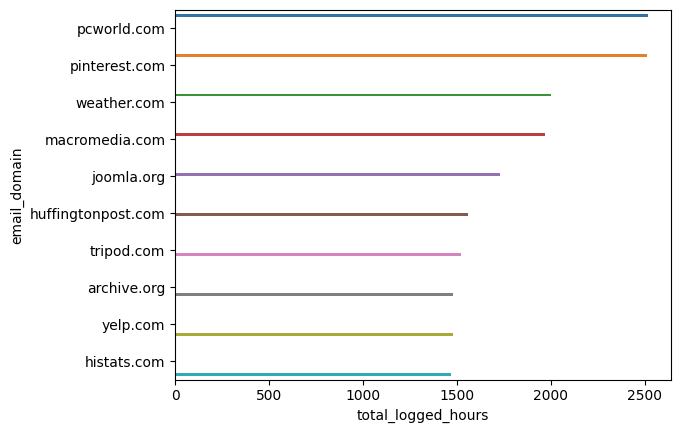

In [49]:
top_3_domains = data_for_analysis.groupby(['email_domain'])['total_logged_hours'].sum().reset_index().sort_values('total_logged_hours',ascending = False).head(10)


# barplot
top_3_domains_barplot = sns.barplot(x = 'total_logged_hours',
            y = 'email_domain',
            hue = 'email_domain',
            data = top_3_domains)

         
# Show the plot
plt.legend([],[], frameon=False)



## Most popular shift
### Evening (6pm to 12am) and afternoon (12pm to 6pm) are the most logged in times

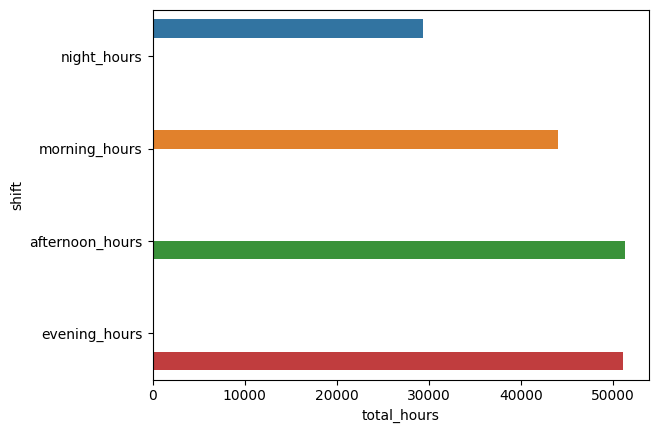

In [51]:
total_time_by_shift = data_for_analysis[['night_hours','morning_hours','afternoon_hours','evening_hours']].sum()

total_time_by_shift_df = pd.DataFrame({'shift':total_time_by_shift.index, 'total_hours':total_time_by_shift.values})

# barplot
total_time_by_shift_df_barplot = sns.barplot(x = 'total_hours',
            y = 'shift',
            hue = 'shift',
            data = total_time_by_shift_df)

         
 
# Show the plot
plt.legend([],[], frameon=False)

# Final Thoughts:
- I would like to play with the concurrency logic to move away from iterating over the whole dataset for each session. It is ok for this size of a dataset but will become much slower on bigger data. 
- Shifting logic can be optimized more
- Spend more time to write an UPSERT function to update the final view instead of overwriting it every time. It should be fine in this case, but in production it should be improved. 